In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg      
import utility as ut
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit as fit
from scipy import stats
import data_import as di
from palettable import wesanderson as wes


In [75]:
# Import behavioural data during training 
path = '/Users/veronikasamborska/Desktop/notebooks_paper/behaviour/training'
def load(path):
    exp = di.Experiment(path)
    return exp
exp= load(path)

Loading new data files..
Importing data file: m478-2018-03-23-102859.txt
Importing data file: m486-2018-03-26-110124.txt
Importing data file: m485-2018-04-05-102203.txt
Importing data file: m479-2018-04-02-174723.txt
Importing data file: m479-2018-04-12-180021.txt
Importing data file: m480-2018-03-27-165956.txt
Importing data file: m480-2018-04-07-124734.txt
Importing data file: m480-2018-03-31-133803.txt
Importing data file: m482-2018-03-23-171756.txt
Importing data file: m482-2018-04-09-175439.txt
Importing data file: m480-2018-04-03-174208.txt
Importing data file: m482-2018-04-06-173954.txt
Importing data file: m485-2018-03-29-113740.txt
Importing data file: m481-2018-03-30-184303.txt
Importing data file: m486-2018-03-21-173234.txt
Importing data file: m482-2018-04-02-115139.txt
Importing data file: m478-2018-03-24-175527.txt
Importing data file: m479-2018-03-30-115524.txt
Importing data file: m485-2018-04-03-104446.txt
Importing data file: m482-2018-03-27-101408.txt
Importing data 

Importing data file: m485-2018-03-24-175527.txt
Importing data file: m483-2018-04-10-172231.txt
Importing data file: m482-2018-04-05-180339.txt
Importing data file: m478-2018-04-09-114234.txt
Importing data file: m478-2018-03-29-113740.txt
Importing data file: m484-2018-04-02-174723.txt
Importing data file: m478-2018-04-05-102203.txt
Importing data file: m483-2018-03-26-175325.txt
Importing data file: m485-2018-03-23-102859.txt
Importing data file: m482-2018-03-25-131104.txt
Importing data file: m481-2018-03-31-133803.txt
Importing data file: m483-2018-04-06-173954.txt
Importing data file: m483-2018-04-09-175439.txt
Importing data file: m481-2018-04-03-174208.txt
Importing data file: m484-2018-03-29-113740.txt
Importing data file: m484-2018-04-05-102203.txt
Importing data file: m479-2018-03-23-102859.txt
Importing data file: m478-2018-04-02-174723.txt
Importing data file: m481-2018-04-07-124734.txt
Importing data file: m481-2018-03-27-165956.txt
Importing data file: m481-2018-03-29-170

In [125]:
def session_plot_moving_average(session, record = False):
    'Plot reward probabilities and moving average of choices for a single session, Figure 1D'
    block=session.trial_data['block']
    choices = session.trial_data['choices']
    n_trials = session.trial_data['n_trials']
    outcome = session.trial_data['outcomes']
    forced_trials = session.trial_data['forced_trial']
    forced_array = np.where(forced_trials == 1)[0]
    forced_trials_sum = sum(forced_trials)
    
    # plot without forced trials 
    choices = np.delete(choices, forced_array); block = np.delete(block, forced_array)
    n_trials = n_trials - forced_trials_sum; outcome =  np.delete(outcome, forced_array)
    exp_average = ut.exp_mov_ave(choices,initValue = 0.5,tau = 8)
    
    plt.figure(figsize = [15,5])
    plt.subplot(3,1,1)
    plt.plot(choices, color = 'grey')
    plt.xlim(1,n_trials)
    plt.yticks([0,1],['B', 'A'])
    plt.ylabel('Choice')

    plt.subplot(3,1,2)
    plt.plot(outcome, color = 'grey')
    plt.xlim(1,n_trials)
    plt.yticks([0,1],['NRew','Rew'])
    plt.ylabel('Outcome')
    
    plt.subplot(3,1,3)
    plt.axhline(y = 0.25, color = 'purple', lw = 0.8)
    plt.axhline(y = 0.75, color = 'purple', lw = 0.8,label = 'Threshold')
    
    block_transitions = block[1:]-block[:-1]
    index_block = np.where(block_transitions == 1)[0]
        
    for i in index_block:
        plt.axvline(x = i,color = 'g',linestyle = '-', lw = '1')
        
    plt.axvline(x = i,color = 'g',linestyle = '-', lw = '1', label = 'Block Change')
    plt.plot(exp_average,'--', color = 'grey')
    plt.ylim(-0,1)
    plt.xlim(1,n_trials)
    plt.ylabel('A Mov Av')
    plt.xlabel('Trials') 
    
    sns.despine()
    plt.legend()

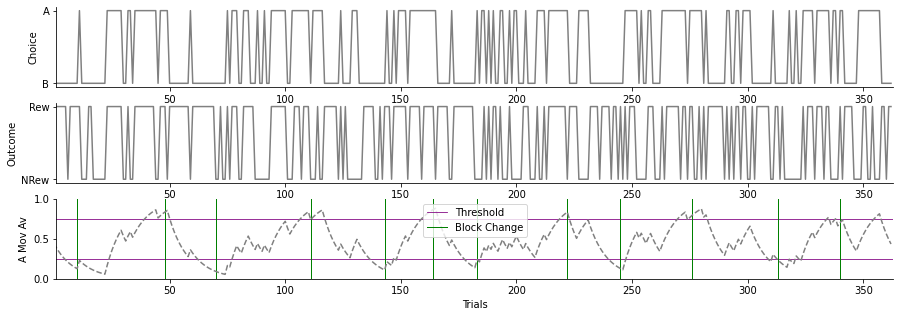

In [126]:
# Plot last session 
# Fig 1D
session_plot_moving_average(exp.sessions[-1],record = False)

In [137]:
def trials_till_reversal_plot(experiment, subject_IDs ='all'):
    'Plot number of trials taken to reach a threshold for a reversal across tasks, Figure 1E'
 
    if subject_IDs == 'all':
        subject_IDs = experiment.subject_IDs
        n_subjects = len(subject_IDs)  

    tasks = 10 
    reversals = 10
    reversal_to_threshold = np.ones(shape=(n_subjects,tasks,reversals)) # subject, task number, reversal number
    reversal_to_threshold[:] = np.NaN  # fill it with NaNs 

    for n_subj, subject_ID in enumerate(subject_IDs):
        subject_sessions = experiment.get_sessions(subject_IDs = [subject_ID])
        task_number = 0 # reset current task number for each subject
        reversal_number = 0 # reset current rev number for each subject
        previous_session_config = 0 #reset config for each subject 
        subject_sessions = experiment.get_sessions(subject_ID)
        trials_from_prev_session = 0
        for j, session in enumerate(subject_sessions):
            sessions_block = session.trial_data['block']
            n_trials = session.trial_data['n_trials']
            prt = (session.trial_data['pre-reversal trials'] > 0).astype(int) # find trials where count till block reversal begins
            
            # delete forced trials
            forced_trials = session.trial_data['forced_trial'] 
            forced_trials_sum = sum(forced_trials)
            forced_array = np.where(forced_trials == 1)[0]
            sessions_block = np.delete(sessions_block, forced_array)
            n_trials = n_trials -  forced_trials_sum
            prt = np.delete(prt, forced_array)
            
            threshold_crossing_trials = np.where((prt[1:] - prt[:-1]) == 1)[0] #find trial indicies where animals crossed a threshold
            block_transitions = sessions_block[1:] - sessions_block[:-1] # find actual block transitions
            reversal_trials = np.where(block_transitions == 1)[0] # indicies of block transitions
            
            configuration = session.trial_data['configuration_i'] # check configuration to detect if it changed from last session
            if configuration[0]!= previous_session_config:
                reversal_number = 0
                task_number += 1 
                trials_from_prev_session = 0
                previous_session_config = configuration[0]  
    
            if len(threshold_crossing_trials) > 0:
                  for i, crossing_trial in enumerate(threshold_crossing_trials): 
                    if reversal_number <= 9:
                        if i == 0: # first element in the threshold_crossing_trials_list 
                            reversal_to_threshold[n_subj, task_number-1, reversal_number] = crossing_trial+trials_from_prev_session
                            trials_from_prev_session = 0
                        elif i > 0: # for other than the first thershold in the session calculate the number of trials since block change
                            reversal_to_threshold[n_subj, task_number-1, reversal_number] = (crossing_trial-reversal_trials[i-1])
                        reversal_number += 1   
            
            # if animals crossed a threshold but session ended before the block change store trials from this session to add to the next
            if len(reversal_trials) != len(threshold_crossing_trials):
                trials_from_prev_session = n_trials - threshold_crossing_trials[i-1]
            # if no threshold crossing occured in the session store trials from this session to add to the next
            elif len(threshold_crossing_trials) == 0:
                trials_from_prev_session = n_trials - forced_trials_sum
   
    # Organize data for ANOVAs
    rev = np.tile(np.arange(10),90); task_n = np.tile(np.repeat(np.arange(10),10),9); n_subj = np.repeat(np.arange(9),100)
    data = np.concatenate(reversal_to_threshold,0); data = np.concatenate(data,0)
     
    anova = {'Data':data,'Sub_id': n_subj,'cond1': task_n, 'cond2':rev}
    anova_pd = pd.DataFrame.from_dict(data = anova)                            
    aovrm_es = pg.rm_anova(anova_pd, dv = 'Data', within=['cond1','cond2'],subject = 'Sub_id' )
    
    # Print stats
    print('Problem:' + ' '+ 'df'+ ' '+str(aovrm_es['ddof1'][0]) + ' ' + str(aovrm_es['ddof2'][0]), 'F' + ' ' + str(aovrm_es['F'][0]),'p-val' + ' '+ str(aovrm_es['p-unc'][0]));
    print('Reversal:' + ' '+ 'df'+ ' '+str(aovrm_es['ddof1'][1]) + ' ' + str(aovrm_es['ddof2'][1]), 'F' + ' ' + str(aovrm_es['F'][1]),'p-val' + ' '+ str(aovrm_es['p-unc'][1]));
    
    # Plot individual subjects
    mean_thre_subj = np.mean(reversal_to_threshold,axis = 2) 
    plt.figure(figsize=(5,5))      
    for i in mean_thre_subj:
        plt.scatter(np.arange(len(i)),i, color = 'grey')
        sns.despine()
        
    mean_threshold = np.mean(reversal_to_threshold,axis = 2) # mean across reversals
    mean_threshold_task = np.mean(mean_threshold, axis = 0) # mean across subjects
    std_threshold_per_task = np.std(mean_threshold, axis = 0) # std across subjects
    sample_size = np.sqrt(9)
    std_err = std_threshold_per_task/sample_size 
    
    # plot means and standard errors across tasks
    x_pos = np.arange(len(mean_threshold_task))
    plt.errorbar(x = x_pos, y = mean_threshold_task, yerr = std_err, alpha=0.8,  linestyle='None', marker='*', color = 'Black')    

    # plot trend line 
    z = np.polyfit(x_pos, mean_threshold_task,1)
    p = np.poly1d(z)
    plt.plot(x_pos,p(x_pos),"--", color = 'grey', label = 'Trend Line')
    plt.xlabel("Problem Number")
    plt.ylabel("Number of Trials Till Threshold")
    plt.xticks(np.arange(10),np.arange(10)+1)
    
    # plot all reversals across all tasks averaged aross subjects 
    x = np.arange(reversals)
    std_proportion = np.std(reversal_to_threshold, axis = 0)
    std_err = std_proportion/sample_size
    mean_thre_subj_all_tasks = np.mean(reversal_to_threshold,axis = 0) 
    
    
    plt.figure(figsize = (20,5))
    colors = wes.Moonrise5_6.mpl_colors+wes.Royal2_5.mpl_colors
    for i in range(tasks): 
         plt.plot(i * reversals + x, mean_thre_subj_all_tasks[i],  color = colors[i], label = 'Problem_'+str(i+1))
         plt.fill_between(i * reversals + x, mean_thre_subj_all_tasks[i] - std_err[i], mean_thre_subj_all_tasks[i]+std_err[i], alpha=0.2 ,color = colors[i])
    plt.xticks(np.arange(100),np.tile(np.arange(10)+1,10))
    plt.legend()
    plt.ylabel('Number of Trials Till Threshold')
    plt.xlabel('Reversal Number')
    sns.despine()
    
   

/Users/veronikasamborska/miniconda3/lib/python3.7/site-packages/pingouin/distribution.py:464: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


Problem: df 9 72 F 3.9066927592247915 p-val 0.0004455944592050573
Reversal: df 9 72 F 3.5202891815283723 p-val 0.0011653266977578822


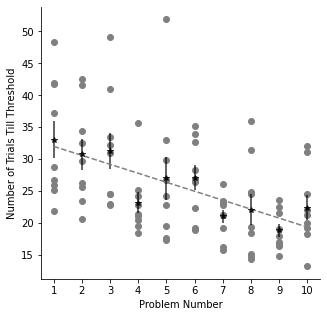

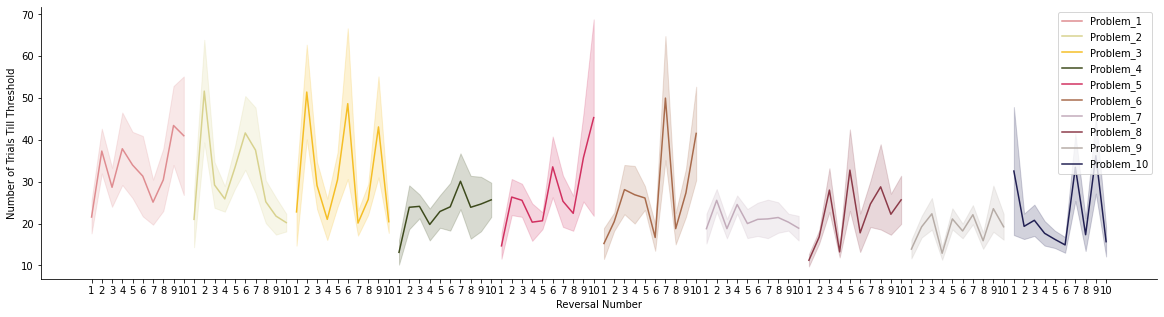

In [138]:
# Fig 1E

trials_till_reversal_plot(exp, subject_IDs ='all')

In [421]:
def meta_learning_reversals(experiment, subject_IDs ='all' , plot_subj = False):
    if subject_IDs == 'all':
        subject_IDs = experiment.subject_IDs
    # number of trials before and after switch
    tr = 10
    a_first = [];  a_last = [];  b_first = [];b_last = []

    for n_subj, subject_ID in enumerate(subject_IDs):
        states_block = []; choices_block = []
        task_number = 0; reversal_number = 0; previous_session_config = 0  
        subject_sessions = experiment.get_sessions(subject_ID)
        
        for j, session in enumerate(subject_sessions):
            sessions_block = session.trial_data['block']
            forced_trials = session.trial_data['forced_trial']
            state = session.trial_data['state']
            choices = session.trial_data['choices'] 
            # delete forced trials
            forced_trials_sum = sum(forced_trials)
            forced_array = np.where(forced_trials == 1)[0]
            sessions_block = np.delete(sessions_block, forced_array)
            block_transitions = sessions_block[1:] - sessions_block[:-1] # block transition
            
            state = np.delete(state,forced_array)
            choices = np.delete(choices,forced_array)   
            
            state_around_block = []; choice_around_block = []
            block_transitions_id = np.where(block_transitions == 1)[0]
                                        
            if len(block_transitions_id) > 1: # if block transition happened during the session
                for b in block_transitions_id:
                    if b > tr and (b + tr) <= len(state): # only take blocks for which all 10 post and 10 pre reversal trials exist in a single session
                        state_around_block.append(state[b - tr: b + tr])
                        choice_around_block.append(choices[b - tr: b + tr])
    
            states_block.append(state_around_block)
            choices_block.append(choice_around_block)
            
        # if session had reversals with enough trials before + after 
        states_block_subj = [x for x in states_block if x != []]; states_block_subj = np.concatenate(states_block_subj,0)
        choices_block_subj = [x for x in choices_block if x != []]; choices_block_subj = np.concatenate(choices_block_subj,0)
        
        # was the block change from A to B or vice versa?
        change_from_a = np.where(states_block_subj[:,tr] == 1)[0]; change_from_b = np.where(states_block_subj[:,tr] == 0)[0]
        a_first.append(np.mean(choices_block_subj[change_from_a[:5]],0)) #first 5 reversals
        a_last.append(np.mean(choices_block_subj[change_from_a[-5:]],0)) #last 5 reversals

        b_first.append(np.mean(choices_block_subj[change_from_b[:5]],0)) #first 5 reversals
        b_last.append(np.mean(choices_block_subj[change_from_b[-5:]],0)) #last 5 reversals
    
    
    mean_a_f = np.mean(a_first,0); std_a_f = np.std(a_first,0)/np.sqrt(9); mean_a_l = np.mean(a_last,0); std_a_l = np.std(a_last,0)/np.sqrt(9)
    mean_b_f = np.mean(b_first,0); std_b_f = np.std(b_first,0)/np.sqrt(9); mean_b_l = np.mean(b_last,0); std_b_l = np.std(b_last,0)/np.sqrt(9)
    
    # fit slopes for choices after block change in the beginning vs late training
    slope_f = []; slope_l = []
    for i,ii in enumerate(a_first):
        after_rev_e = np.mean([1-a_first[i],b_first[i]],0)[tr:] # reverse A to B --> to the same sign as B to A (Correct vs Incorrect)
        after_rev_l = np.mean([1-a_last[i],b_last[i]],0)[tr:] # reverse A to B --> to the same sign as B to A (Correct vs Incorrect)
        sl_f = np.polyfit(np.arange(len(after_rev_e)), after_rev_e,1)
        sl_l = np.polyfit(np.arange(len(after_rev_l)), after_rev_l,1)
        slope_f.append(sl_f[0]); slope_l.append(sl_l[0])
        
    # t-test to compare slopes across animals
    stat = stats.ttest_rel(slope_f,slope_l)
    print('df', (len(slope_f)*2)-1, ' ' + str(stat))
     
    # reverse A to B --> to the same sign as B to A (Correct vs Incorrect)
    correct_first = np.mean([1-mean_a_f,mean_b_f],0);  correct_first_std  = np.mean([std_a_f,std_b_f],0)
    correct_last = np.mean([1-mean_a_l,mean_b_l],0); correct_last_std  = np.mean([std_a_l,std_b_l],0)
    
    subj_f = np.mean([1-np.asarray(a_first), np.asarray(b_first)],0)
    subj_l = np.mean([1-np.asarray(a_last), np.asarray(b_last)],0)

    if plot_subj == True:    
        for i in subj_f:
            plt.scatter(np.arange(len(i)),i, color = 'grey')
        for i in subj_l:
            plt.scatter(np.arange(len(i)),i, color = 'black')
            
    plt.plot(correct_first, color = 'grey')
    plt.fill_between(np.arange(len(correct_first)), correct_first-correct_first_std, correct_first+correct_first_std, alpha=0.1,color ='grey', label = 'first 10 blocks')
    plt.plot(correct_last, color = 'black')
    plt.fill_between(np.arange(len(correct_last)), correct_last-correct_last_std, correct_last+correct_last_std, alpha=0.1,color ='black', label = 'last 10 blocks')
    plt.vlines([tr-0.5],ymin = 0, ymax = 1)
    plt.xticks(np.arange(tr*2), np.arange(tr*2)+1)
    plt.yticks([0,1], ['C', 'InC'])
    plt.legend()
    sns.despine()
 

df 17  Ttest_relResult(statistic=-5.004667820125432, pvalue=0.0010467061211763102)


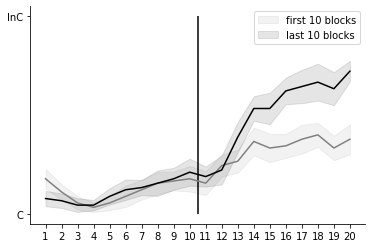

In [420]:
meta_learning_reversals(exp, subject_IDs ='all')



In [384]:
def out_of_sequence(experiment, subject_IDs = 'all'):
    # code to extract out of sequence pokes, Figure 1G
    
    if subject_IDs == 'all':
        subject_IDs = experiment.subject_IDs
        n_subjects = len(subject_IDs)  
   
    tasks = 10 
    bad_pokes = np.zeros([n_subjects,tasks,10])  # subject, task number, reversal number
    bad_pokes[:] = np.NaN # fill it with NaNs 
    
    for n_subj, subject_ID in enumerate(subject_IDs):
        
        subject_sessions = experiment.get_sessions(subject_ID)
        previous_session_config = 0 # initiate previous configuration
        task_number = 0 # initiate task number
        all_sessions_wrong_ch = [] # get the list with only trials that were treated as trials in task programme
        all_reversals = []
        all_tasks = []

        for j, session in enumerate(subject_sessions): 
            trials = session.trial_data['n_trials']
            sessions_block = session.trial_data['block']
            forced_trials = session.trial_data['forced_trial']
            forced_array = np.where(forced_trials == 1)[0] 
            trials = trials - len(forced_array) 
            configuration = session.trial_data['configuration_i'] 
            poke_A = 'poke_'+str(session.trial_data['poke_A'][0])
            poke_B = 'poke_'+str(session.trial_data['poke_B'][0])
            
            sessions_block = np.delete(sessions_block, forced_array)
            block_transitions = sessions_block[1:] - sessions_block[:-1] # Block transition
            reversal_trials = np.where(block_transitions == 1)[0]        
            
            # find events of interest
            events = [event.name for event in session.events if event.name in ['a_forced_state','b_forced_state','choice_state', 'init_trial','sound_b_no_reward', 'sound_b_reward','sound_a_no_reward','sound_a_reward',poke_A, poke_B]]
            session_wrong_choice = []
            
            # go through events list and find the events of interest 
            wrong_count = 0
            choice_state = False
            prev_choice = 'forced_trial'
            
            for event in events:
                if event == 'choice_state':
                    session_wrong_choice.append(wrong_count)
                    wrong_count = 0
                    choice_state = True
                
                elif event == poke_A : 
                    if choice_state == True:
                        prev_choice = 'Poke_A'
                        choice_state = False
                    elif choice_state == False and  prev_choice == 'Poke_B':
                        if event == poke_B:
                            wrong_count += 1 
                                
                elif event == poke_B : 
                    if choice_state == True:
                        prev_choice = 'Poke_B'
                        choice_state = False
                    elif choice_state == False and prev_choice == 'Poke_A':
                        if event == poke_B:
                            wrong_count += 1 
                
                elif event == 'a_forced_state' or event == 'b_forced_state':
                    prev_choice  = 'forced_state' #don't include forced trials
                    
                
            if j == 0: 
                all_sessions_wrong_ch = session_wrong_choice[:trials]
                
            elif j > 0: 
                all_sessions_wrong_ch += session_wrong_choice[:trials]
                
             
            if configuration[0]!= previous_session_config:
                reversal_number = 0
                task_number += 1
                previous_session_config = configuration[0]  
            
            for i in range(trials):
                for r in reversal_trials:
                    if i == r:
                        reversal_number += 1
                all_reversals.append(reversal_number)
                all_tasks.append(task_number)
                        
        reversals_np = np.asarray(all_reversals)+1 # Make all reversals start at 1 (not 0)
        pokes_np = np.asarray(all_sessions_wrong_ch)
        tasks_np = np.asarray(all_tasks)

        for r in range(1,11):
            for t  in range(1,11):
                wrong_p = pokes_np[(tasks_np==t) & (reversals_np==r)]# For plots from all trials 
                mean_pokes = np.mean(wrong_p)     
                bad_pokes[n_subj,t-1,r-1] = mean_pokes 
                
        
    # bad_pokes = bad_pokes[:,1:,:]
    
    
    # rev = np.tile(np.arange(10),81)
    # task_n = np.tile(np.repeat(np.arange(9),10),9)
    # n_subj =np.repeat(np.arange(9),90)
    # data = np.concatenate(bad_pokes,0)
    # data = np.concatenate(data,0) 

    # # for task in range(tasks):
    # #     pd.DataFrame(data=all_subjects[:,task,:]).to_csv('task{}_reversals_recording.csv'.format(task))

    # anova = {'Data':data,'Sub_id': n_subj,'cond1': task_n, 'cond2':rev}
    
    # anova_pd = pd.DataFrame.from_dict(data = anova)
                                      
    # aovrm_es = pg.rm_anova(anova_pd, dv = 'Data', within=['cond1','cond2'],subject = 'Sub_id' )
    # #posthoc = pg.pairwise_ttests(data=anova_pd, dv='Data',within=['cond2'],subject = 'Sub_id',\
    # #                         parametric=True, padjust='fdr_bh', effsize='hedges')
 
    # 
    
    rev = np.tile(np.arange(10),90)
    task_n = np.tile(np.repeat(np.arange(10),10),9)
    n_subj =np.repeat(np.arange(9),100)
    data = np.concatenate(bad_pokes,0)
    data = np.concatenate(data,0) 

    # for task in range(tasks):
    #     pd.DataFrame(data=all_subjects[:,task,:]).to_csv('task{}_reversals_recording.csv'.format(task))

    anova = {'Data':data,'Sub_id': n_subj,'cond1': task_n, 'cond2':rev}
    
    anova_pd = pd.DataFrame.from_dict(data = anova)
                                      
    aovrm_es = pg.rm_anova(anova_pd, dv = 'Data', within=['cond1','cond2'],subject = 'Sub_id' )
    #posthoc = pg.pairwise_ttests(data=anova_pd, dv='Data',within=['cond2'],subject = 'Sub_id',\
    #                         parametric=True, padjust='fdr_bh', effsize='hedges')
 
    print(aovrm_es['p-unc'])
    print(aovrm_es['F'])
    print(aovrm_es['ddof1'])
    print( aovrm_es['ddof2'])

    #Mean Pokes 
    median_bad_pokes=np.mean(bad_pokes,axis = 2)
    
    # plt.figure(figsize=(10,10))

    # k = 0
    # for i in median_bad_pokes:
    #     plt.scatter(np.arange(len(i)),i, color = 'grey')
    #     sns.despine()
        
   
    # median_bad_pokes = np.mean(median_bad_pokes, axis = 0)
    # std_bad_pokes_med= np.std(median_bad_pokes, axis = 0)
    # sample_size=np.sqrt(9)
    # std_err_median= std_bad_pokes_med/sample_size
    # x_pos = np.arange(len(median_bad_pokes))
    # sns.set(style="white", palette="muted", color_codes=True)

    # plt.errorbar(x = x_pos, y = median_bad_pokes, yerr = std_err_median, alpha=0.8,  linestyle='None', marker='*', color = 'Black')    
    # x_pos_no_NaNs = np.delete(x_pos, 0)
    # median_threshold_per_task_no_NaNs = np.delete(median_bad_pokes, 0)
    # z = np.polyfit(x_pos_no_NaNs, median_threshold_per_task_no_NaNs,1)
    # p = np.poly1d(z)
    # plt.plot(x_pos,p(x_pos),"--", color = 'grey', label = 'Trend Line')
    # plt.xlabel("Task Number")
    
  
    
    # plt.figure(figsize=(10,5))
    # reversals = 10
    # x=np.arange(reversals)
    # bad_pokes_mean = np.mean(bad_pokes,axis = 0)
    # bad_pokes_ser = (np.std(bad_pokes,axis = 0))/np.sqrt(9)
    # x=np.arange(reversals)

    # for i in range(tasks): 
    #      plt.plot(i * reversals + x, bad_pokes_mean[i],  color = 'grey')
    #      plt.fill_between(i * reversals + x, bad_pokes_mean[i]-bad_pokes_ser[i], bad_pokes_mean[i]+bad_pokes_ser[i], alpha=0.2,  color = 'grey')
    # plt.ylabel('Number of A/B pokes')
    # plt.xlabel('Reversal Number')
   

In [120]:
out_of_sequence(exp, subject_IDs = 'all')

0    6.810765e-14
1    2.233769e-05
2    6.706000e-12
Name: p-unc, dtype: float64
0    15.788218
1     5.144691
2     2.689462
Name: F, dtype: float64
0     9
1     9
2    81
Name: ddof1, dtype: int64
0     72
1     72
2    648
Name: ddof2, dtype: int64


/Users/veronikasamborska/miniconda3/lib/python3.7/site-packages/pingouin/distribution.py:464: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


In [331]:
def meta_learning_trial(experiment, subject_IDs = 'all'):
    # code to extract out of sequence pokes, Figure 1H
    
